In [234]:
%%capture

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential


In [236]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [238]:
crypto_currency = "BTC"
against_currency = "USD"

sentiment_df = pd.read_csv("sentiment_data_consolidated.csv")
sentiment = sentiment_df["sentiment"]

start = dt.datetime.strptime(sentiment_df["time"].iloc[0], "%Y-%m-%d")
end = dt.datetime.strptime(sentiment_df["time"].iloc[-2], "%Y-%m-%d")

raw_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", start, end)

In [237]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(raw_data["Close"].values.reshape(-1,1))

In [205]:
prediction_days = 60
X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_buff = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = []

for i, x in enumerate(range(prediction_days, len(scaled_data))):
    X_train.append(np.insert(X_buff[i],1, sentiment[x - prediction_days:x], 1))

X_train = np.array(X_train)

(1858, 60, 2)

In [206]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")

with tf.device('/cpu:0'):
    model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 8s 67ms/step - loss: 0.0047
Epoch 2/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0013
Epoch 3/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0015
Epoch 4/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0010
Epoch 5/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0011
Epoch 6/25
59/59 [==============================] - 4s 68ms/step - loss: 0.0014
Epoch 7/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0010
Epoch 8/25
59/59 [==============================] - 4s 67ms/step - loss: 0.0011
Epoch 9/25
59/59 [==============================] - 4s 69ms/step - loss: 9.3214e-04
Epoch 10/25
59/59 [==============================] - 4s 69ms/step - loss: 0.0012
Epoch 11/25
59/59 [==============================] - 4s 69ms/step - loss: 8.4689e-04
Epoch 12/25
59/59 [==============================] - 4s 70ms/step - loss: 8.7566e-04
Epoch 13/25
59/59 [======

In [240]:
test_start = dt.datetime(2020, 1,1)
test_end = end

raw_test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)
total_dataset = pd.concat((raw_data["Close"], raw_test_data["Close"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(raw_test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

X_test = np.array(X_test)
X_buff = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = []

for i, x in enumerate(range(prediction_days, len(model_inputs))):
    X_test.append(np.insert(X_buff[i],1, sentiment[x - prediction_days:x], 1))
    
X_test = np.array(X_test)

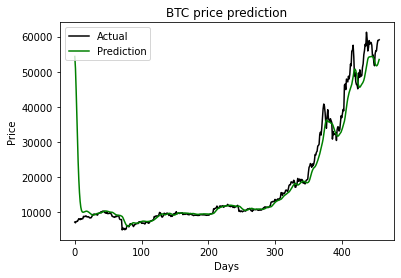

In [256]:
y_pred = model.predict(X_test)

actual_prices = raw_test_data["Close"].values
prediction_prices = scaler.inverse_transform(y_pred)

plt.plot(actual_prices, color="black", label="Actual")
plt.plot(prediction_prices, color="green", label="Prediction")

plt.title(f"{crypto_currency} price prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()